# Real / Fake Job Posting Prediction - We have to classify the fake jobs to that of real jobs

### About Dataset

This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
import time

In [2]:
df1 = pd.read_csv('fake_job_postings.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
df1.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df1 = df1.drop(columns = ['job_id'])

In [6]:
#filling null values, 'Not Applicable' and 'Unspecified' with 'Not Specified'
df1.fillna('Not Specified', inplace=True)
df1 = df1.replace(['Not Applicable','Unspecified'],'Not Specified')

In [7]:
#Label counts for each attribute
labelcountlist = []
for x in df1.columns:
        labelcountlist.append((len(df1[x].unique())))
labelcount = pd.DataFrame({'Attribute': df1.columns, 'Count': labelcountlist})
print(labelcount)

              Attribute  Count
0                 title  11231
1              location   3106
2            department   1338
3          salary_range    875
4       company_profile   1710
5           description  14802
6          requirements  11969
7              benefits   6206
8         telecommuting      2
9      has_company_logo      2
10        has_questions      2
11      employment_type      6
12  required_experience      7
13   required_education     13
14             industry    132
15             function     38
16           fraudulent      2


In [8]:
df1.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,Not Specified,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Not Specified,0,1,0,Other,Internship,Not Specified,Not Specified,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Not Specified,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Specified,Not Specified,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Not Specified,Not Specified,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Not Specified,0,1,0,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Not Specified,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",Not Specified,Not Specified,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
#STORING ALL THOSE ATTRIBUTES WITH LESS THAN 100 LABELS FOR COMPREHENSIBLE VISUALIZATION USING BAR GRAPHS
#AlSO DISPLAYS THE COUNT OF EVERY LABEL IN EACH ATTRIBUTE

print(labelcount[labelcount['Count'] < 100])

              Attribute  Count
8         telecommuting      2
9      has_company_logo      2
10        has_questions      2
11      employment_type      6
12  required_experience      7
13   required_education     13
15             function     38
16           fraudulent      2


In [10]:
count = 0
label = []
for x in df1.columns:
    if len(df1[x].unique()) < 100:
        print('\n' + x + '\n----------\n' + str(list(df1[x].unique())) + "\n")
        print(df1[x].value_counts())
        label.append(x)


telecommuting
----------
[0, 1]

0    17113
1      767
Name: telecommuting, dtype: int64

has_company_logo
----------
[1, 0]

1    14220
0     3660
Name: has_company_logo, dtype: int64

has_questions
----------
[0, 1]

0    9088
1    8792
Name: has_questions, dtype: int64

employment_type
----------
['Other', 'Full-time', 'Not Specified', 'Part-time', 'Contract', 'Temporary']

Full-time        11620
Not Specified     3471
Contract          1524
Part-time          797
Temporary          241
Other              227
Name: employment_type, dtype: int64

required_experience
----------
['Internship', 'Not Specified', 'Mid-Senior level', 'Associate', 'Entry level', 'Executive', 'Director']

Not Specified       8166
Mid-Senior level    3809
Entry level         2697
Associate           2297
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

required_education
----------
['Not Specified', "Bachelor's Degree", "Master's Degree", 'Hi

In [11]:
label.remove('fraudulent')
print(label)

['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'function']


In [12]:
#FUNCTION TO PLOT ATTRIBUTE vs KEY LABEL GRAPHS FOR ATTRIBUTES IN label[]
def plots(lab1,lab2):
    #lab1 = label[0]
    #lab2 = 'fraudulent'
    sns.set(rc={'figure.figsize':(20,40)})
    ax = sns.countplot(data = df1,x=df1[lab1],hue=df1[lab2])

    for p in ax.patches:
       ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.xticks(rotation=90)

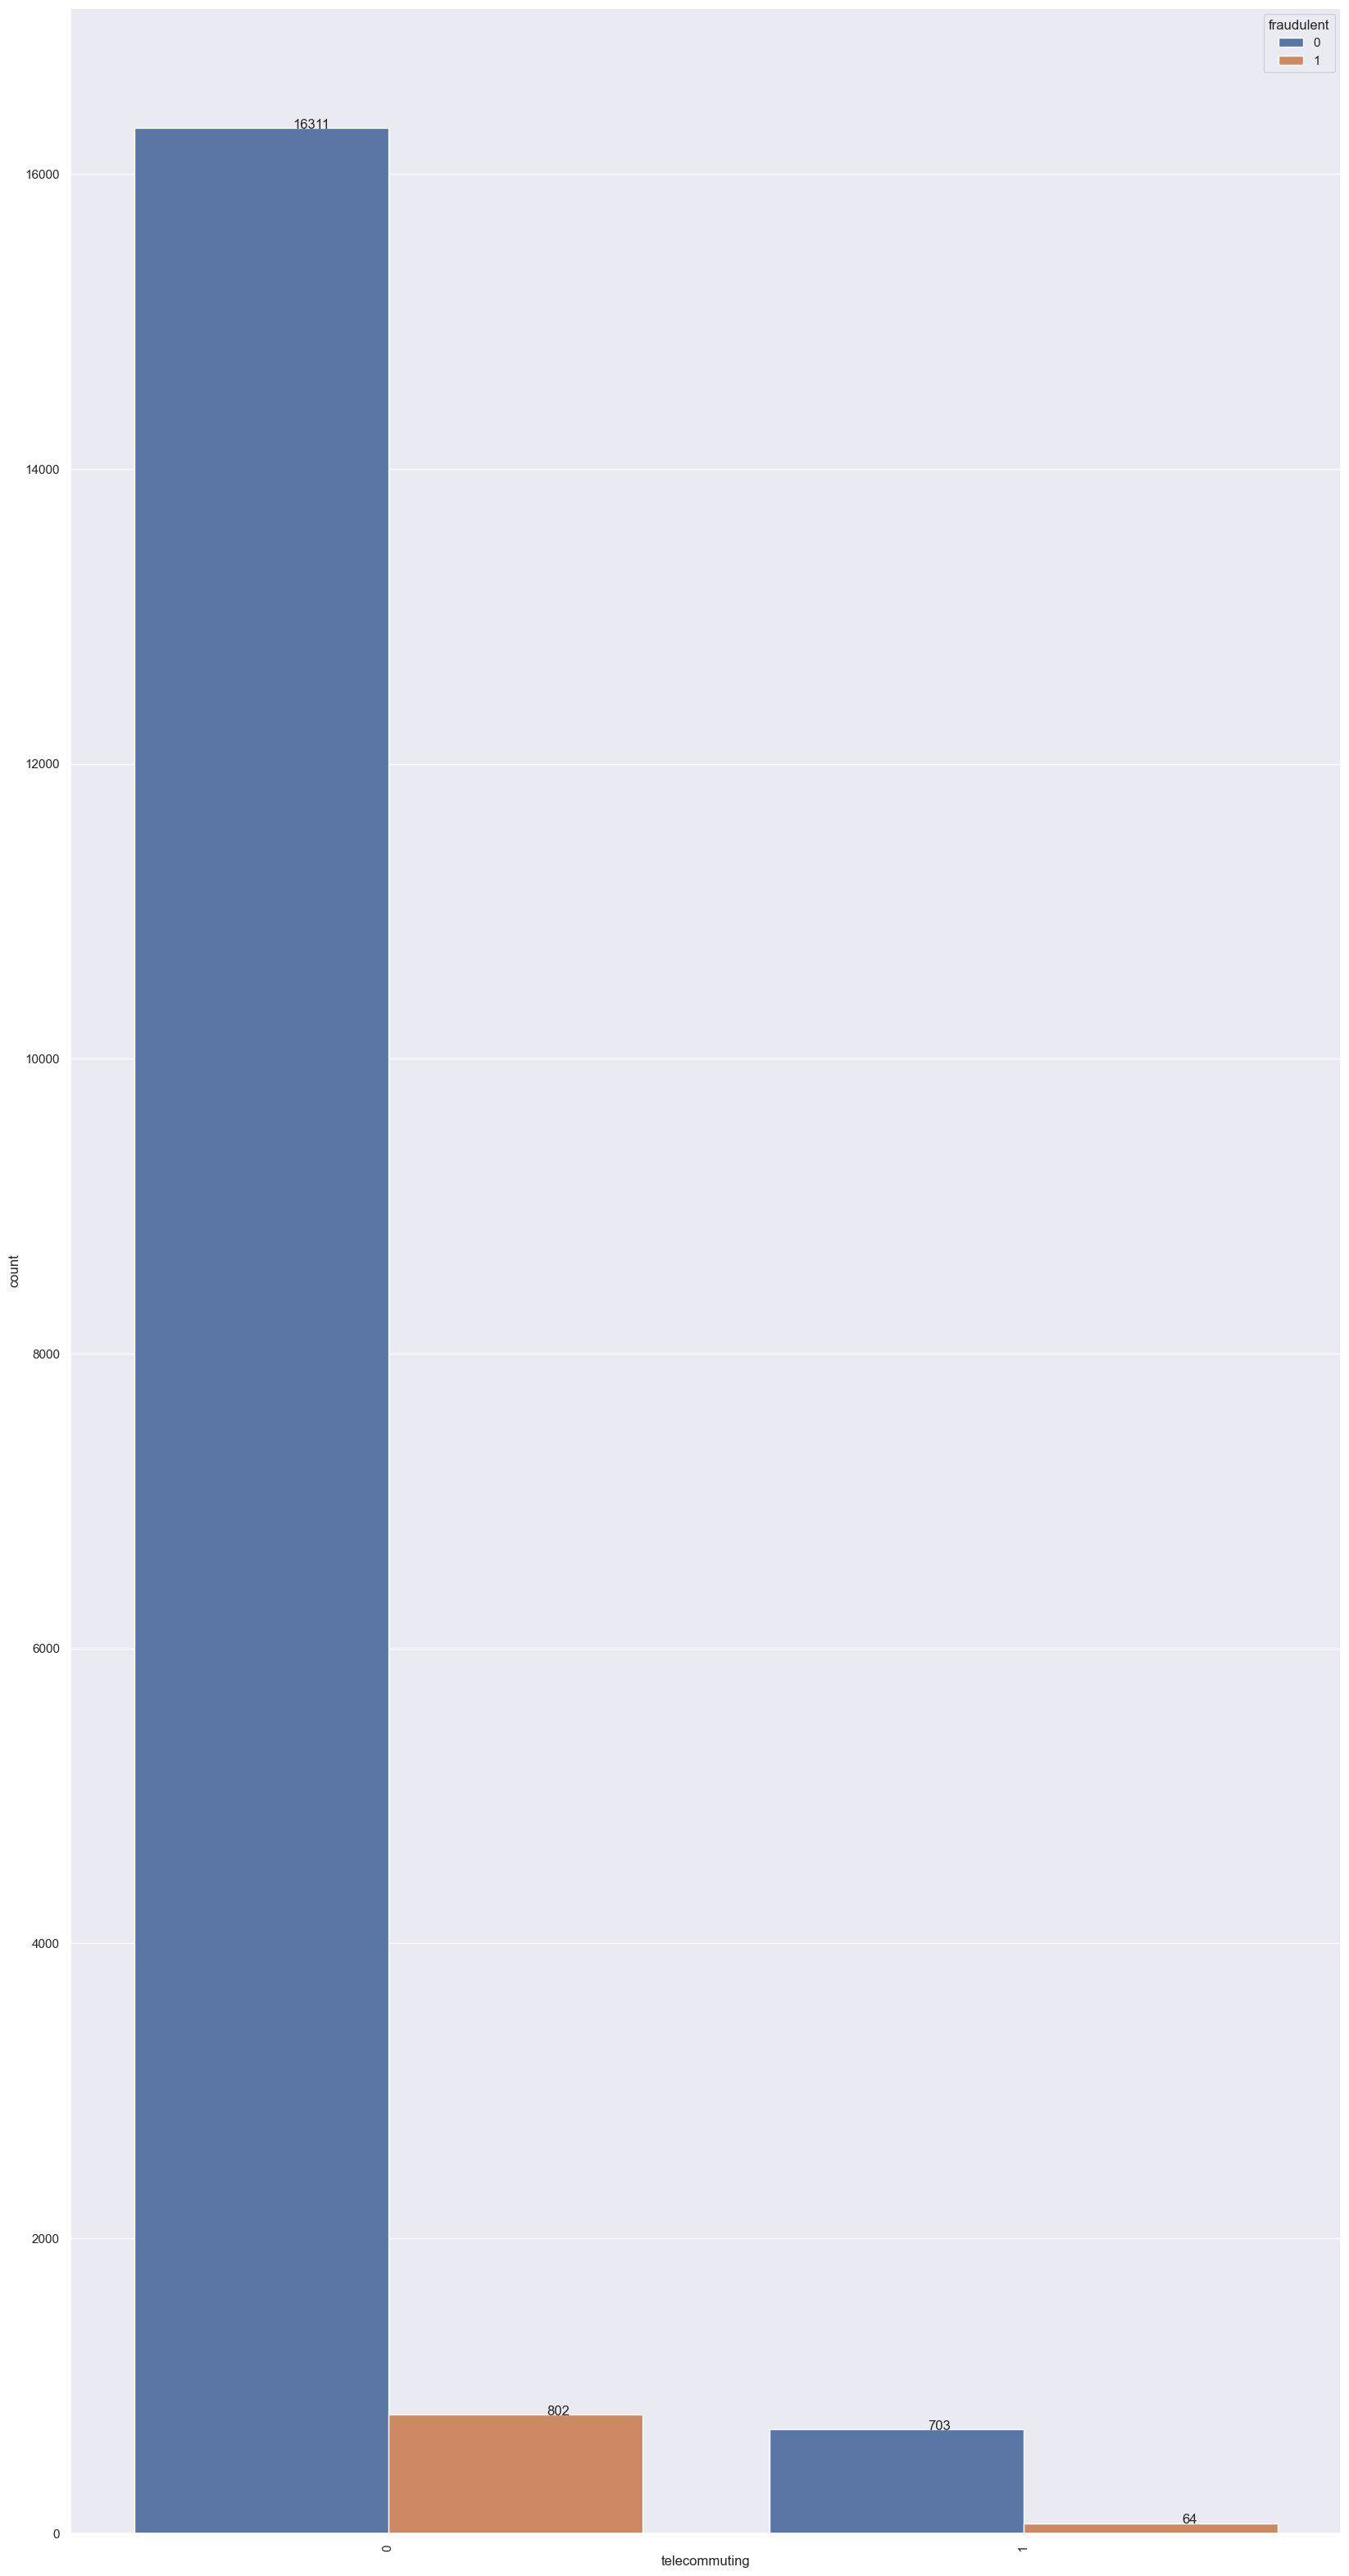

In [13]:
plots(label[0],'fraudulent')#telecommuting

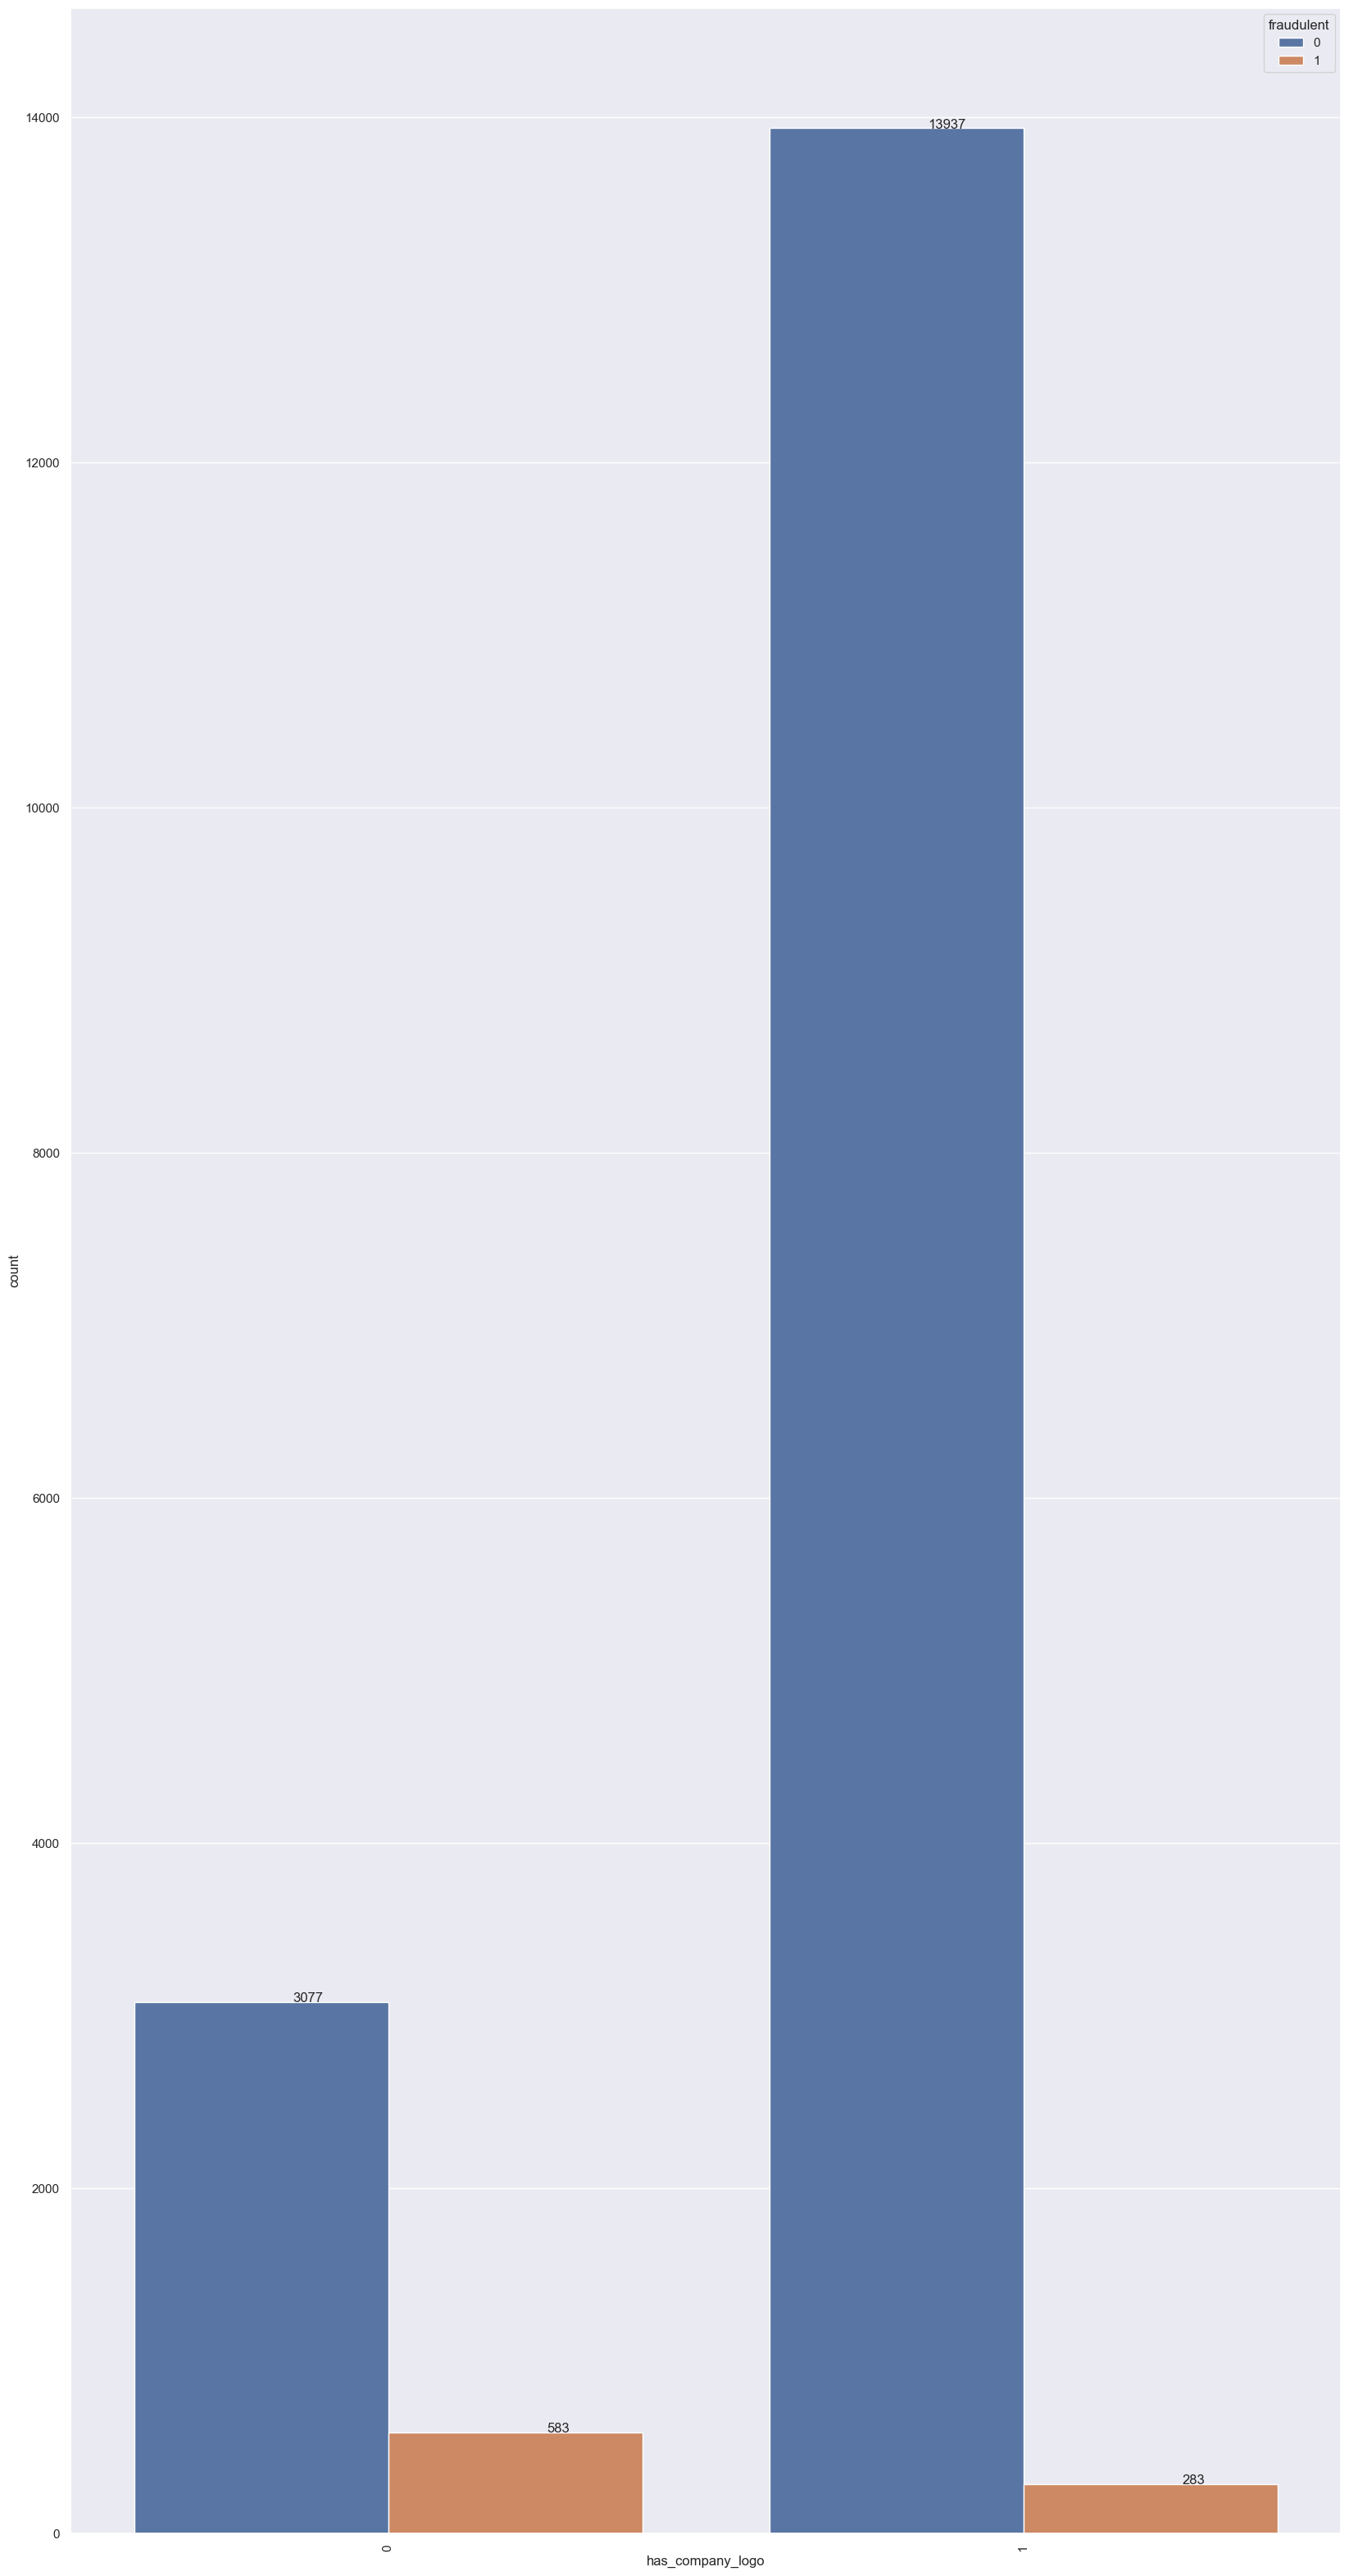

In [14]:
plots(label[1],'fraudulent')#has_company_logo

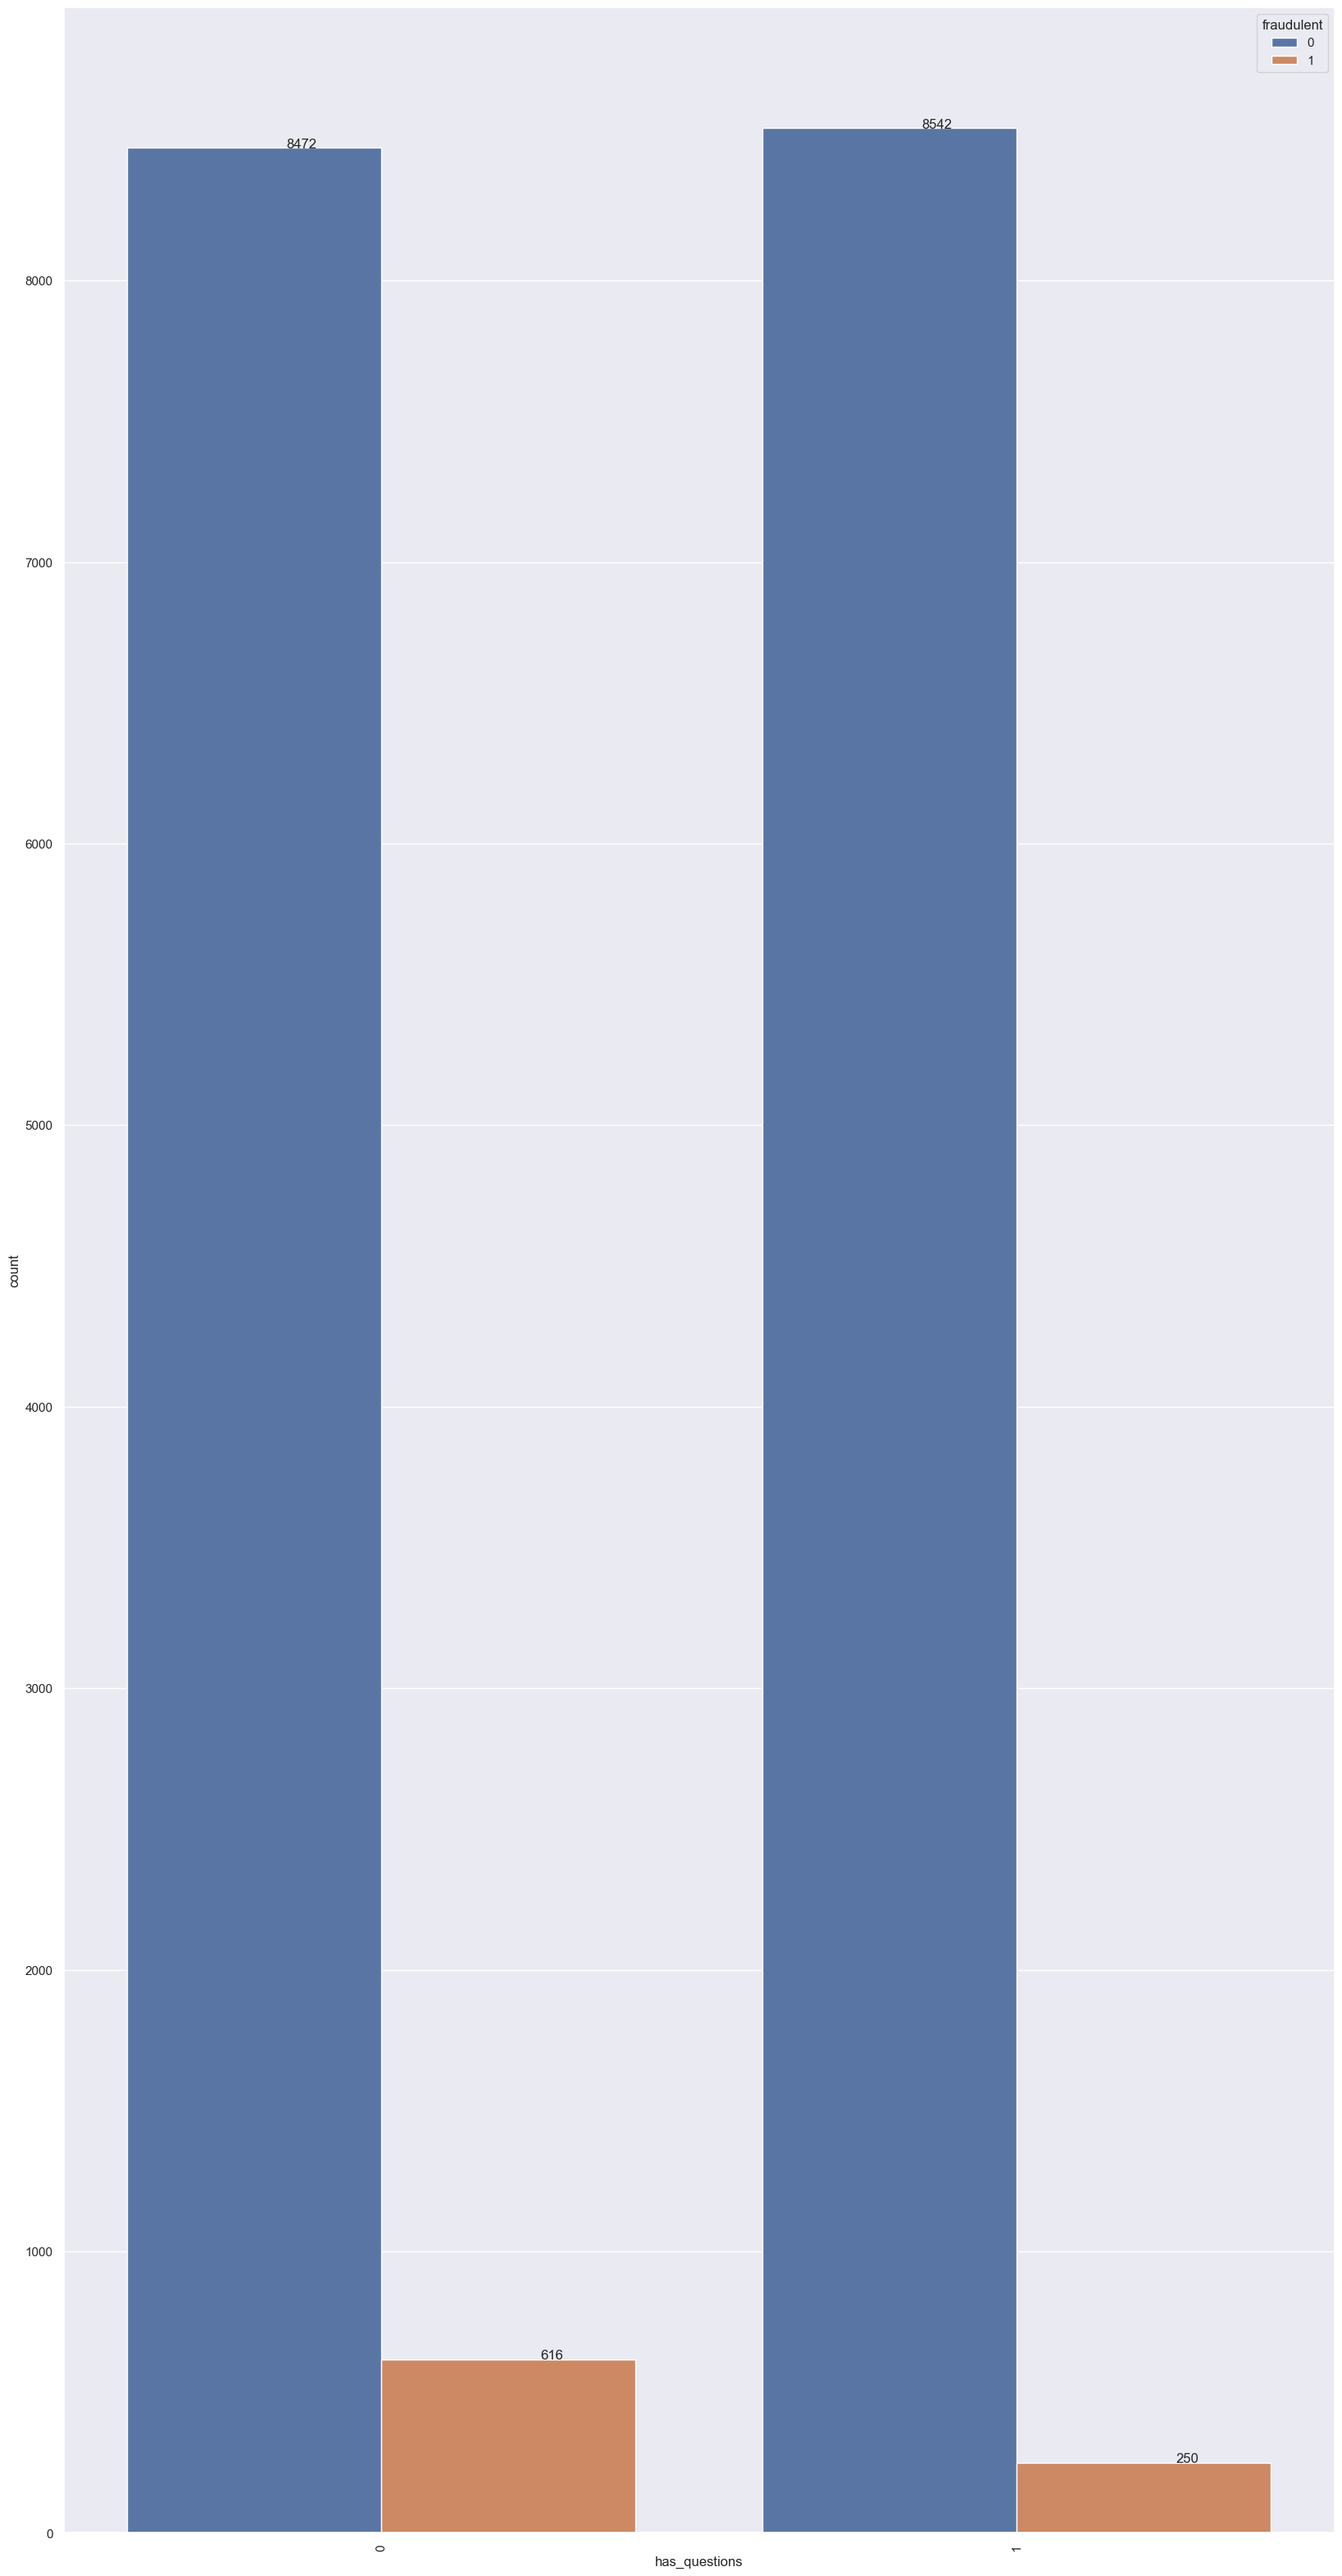

In [15]:
plots(label[2],'fraudulent')#has_questions

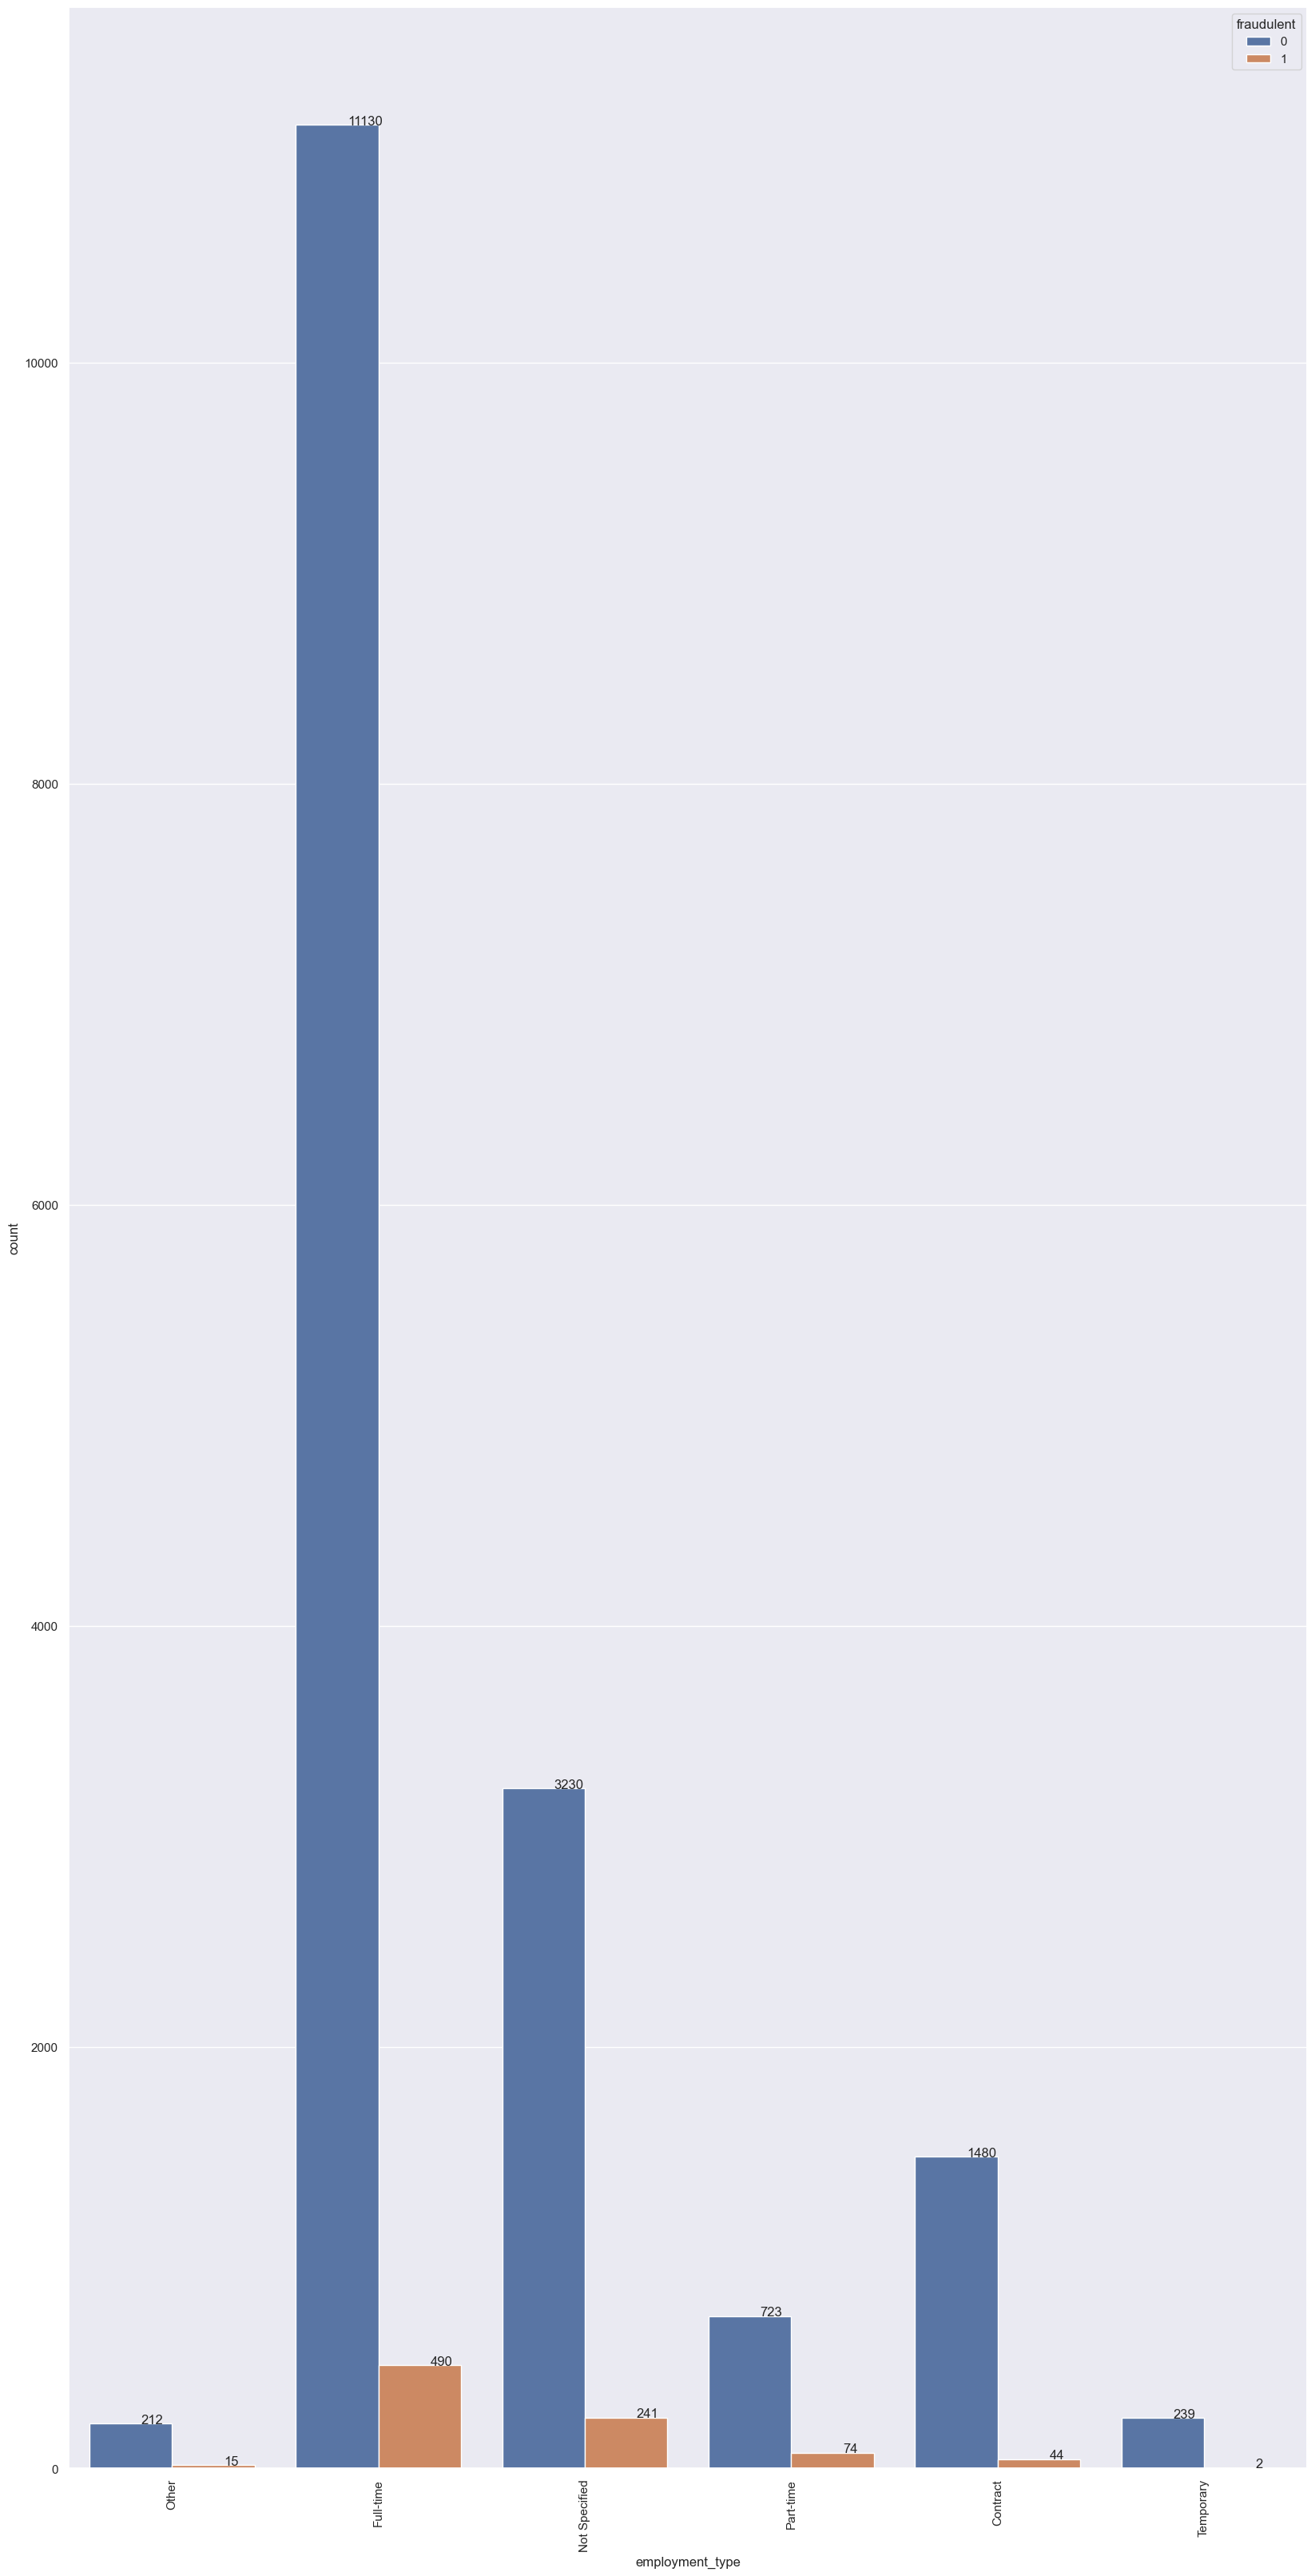

In [16]:
plots(label[3],'fraudulent')#employement_type

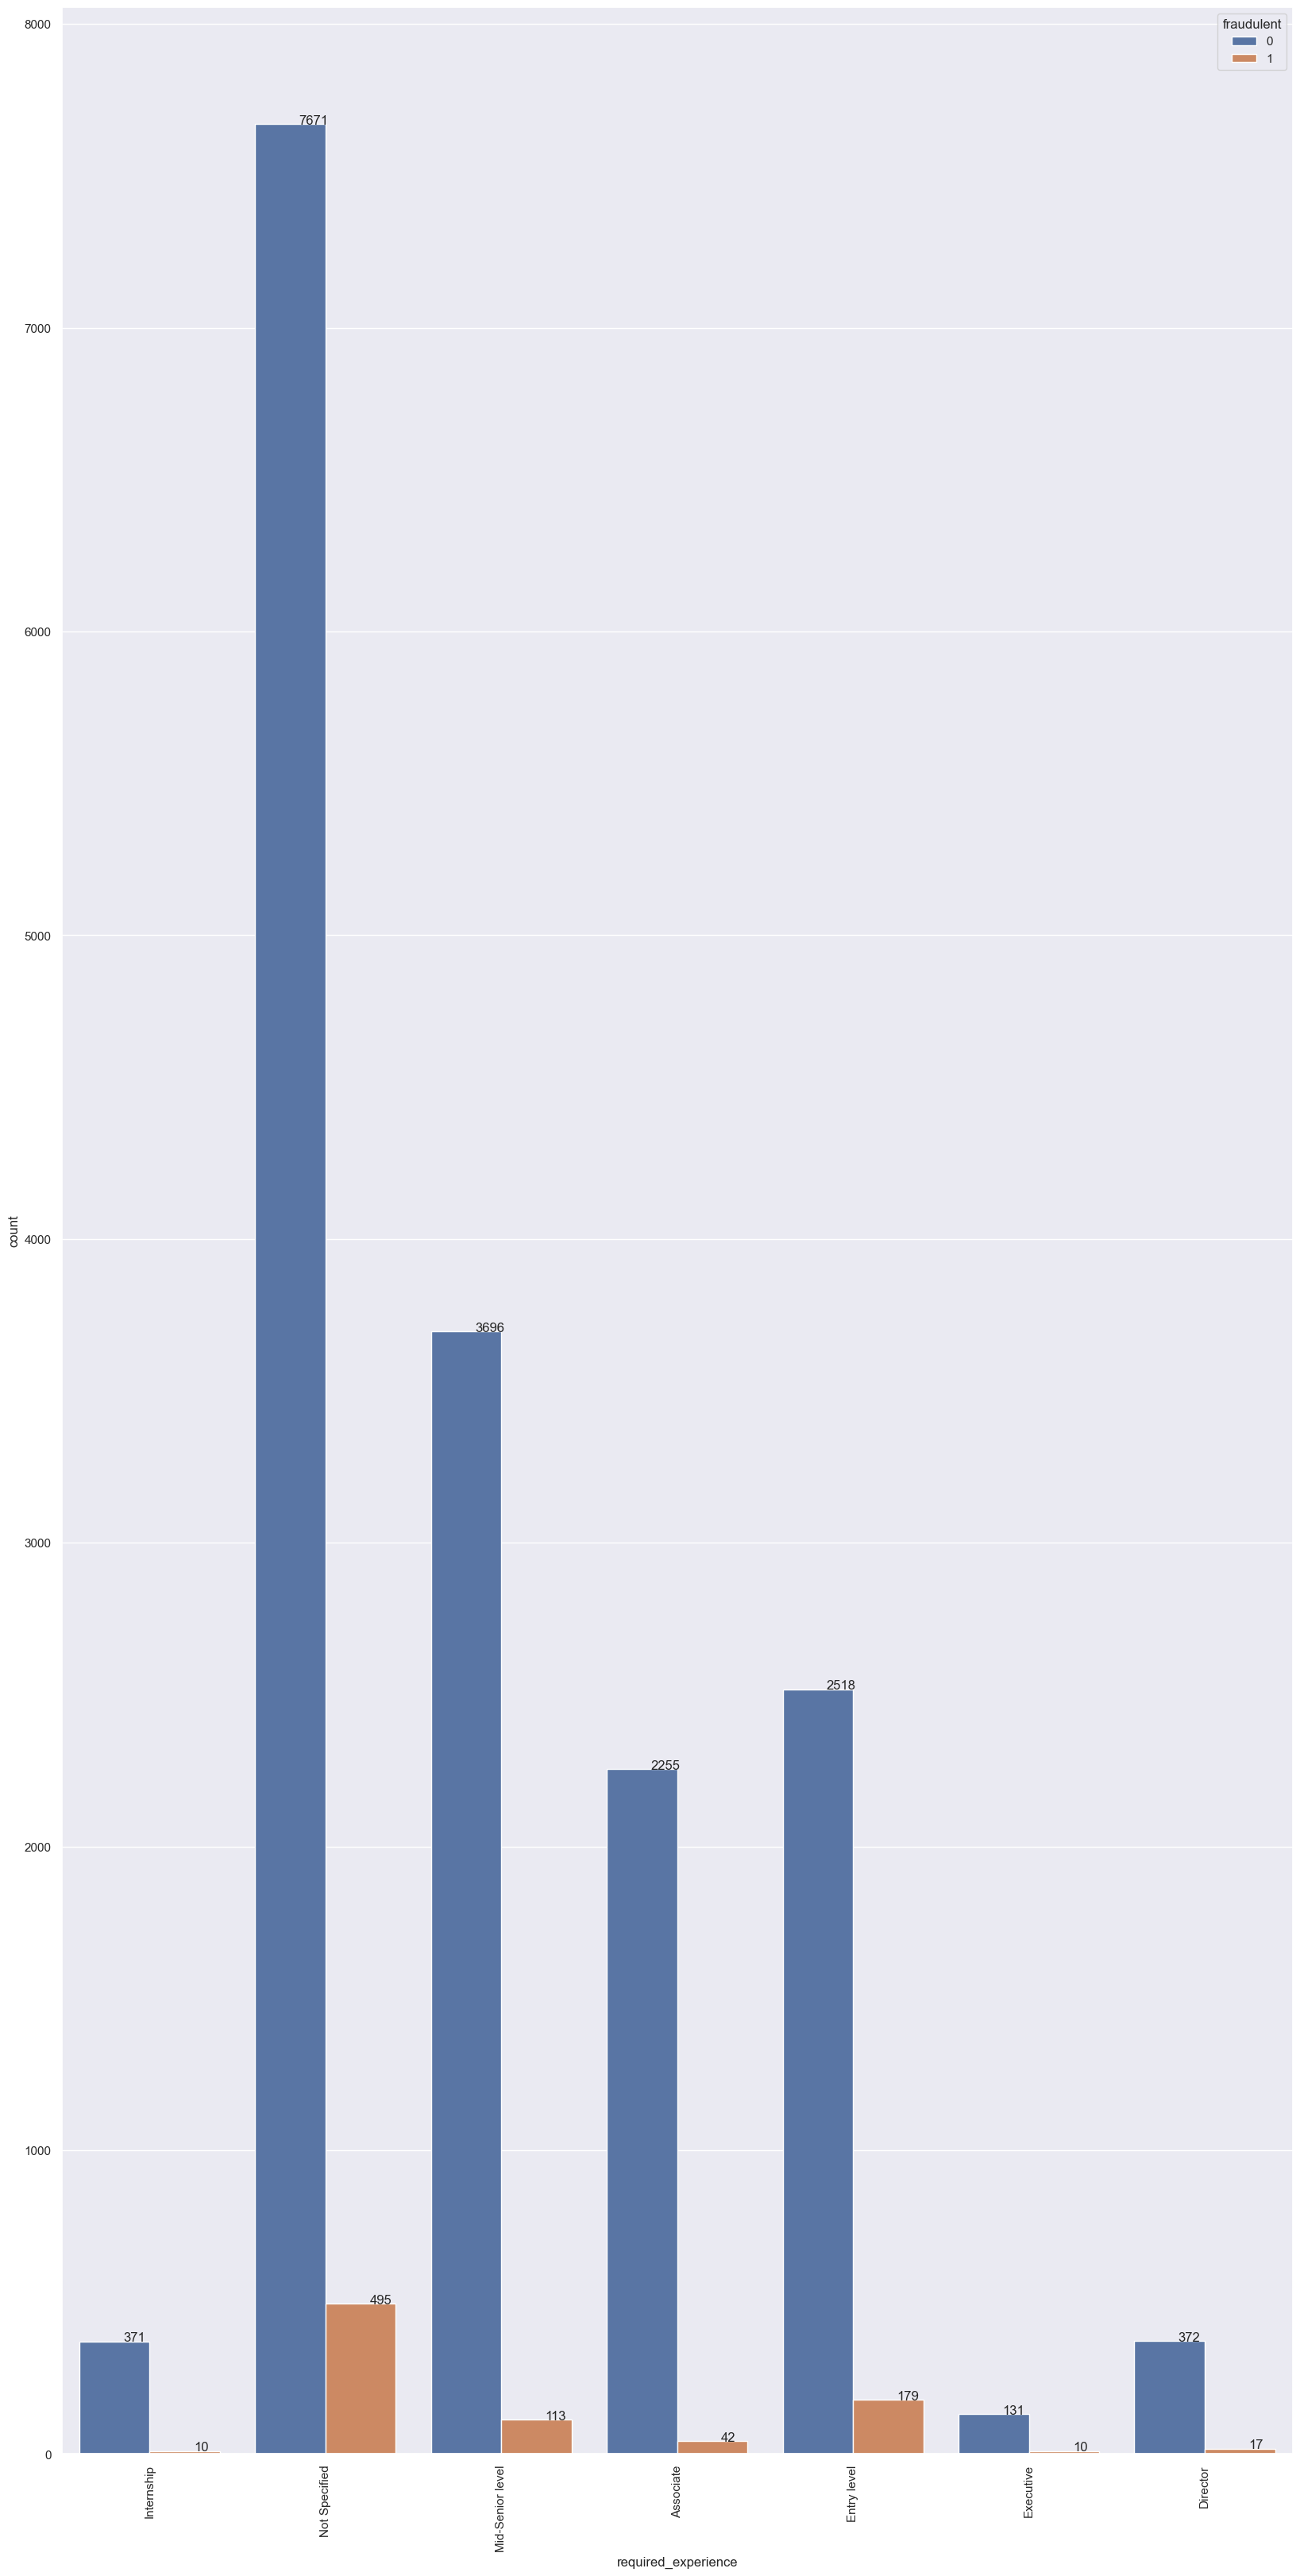

In [17]:
plots(label[4],'fraudulent')#required_experience

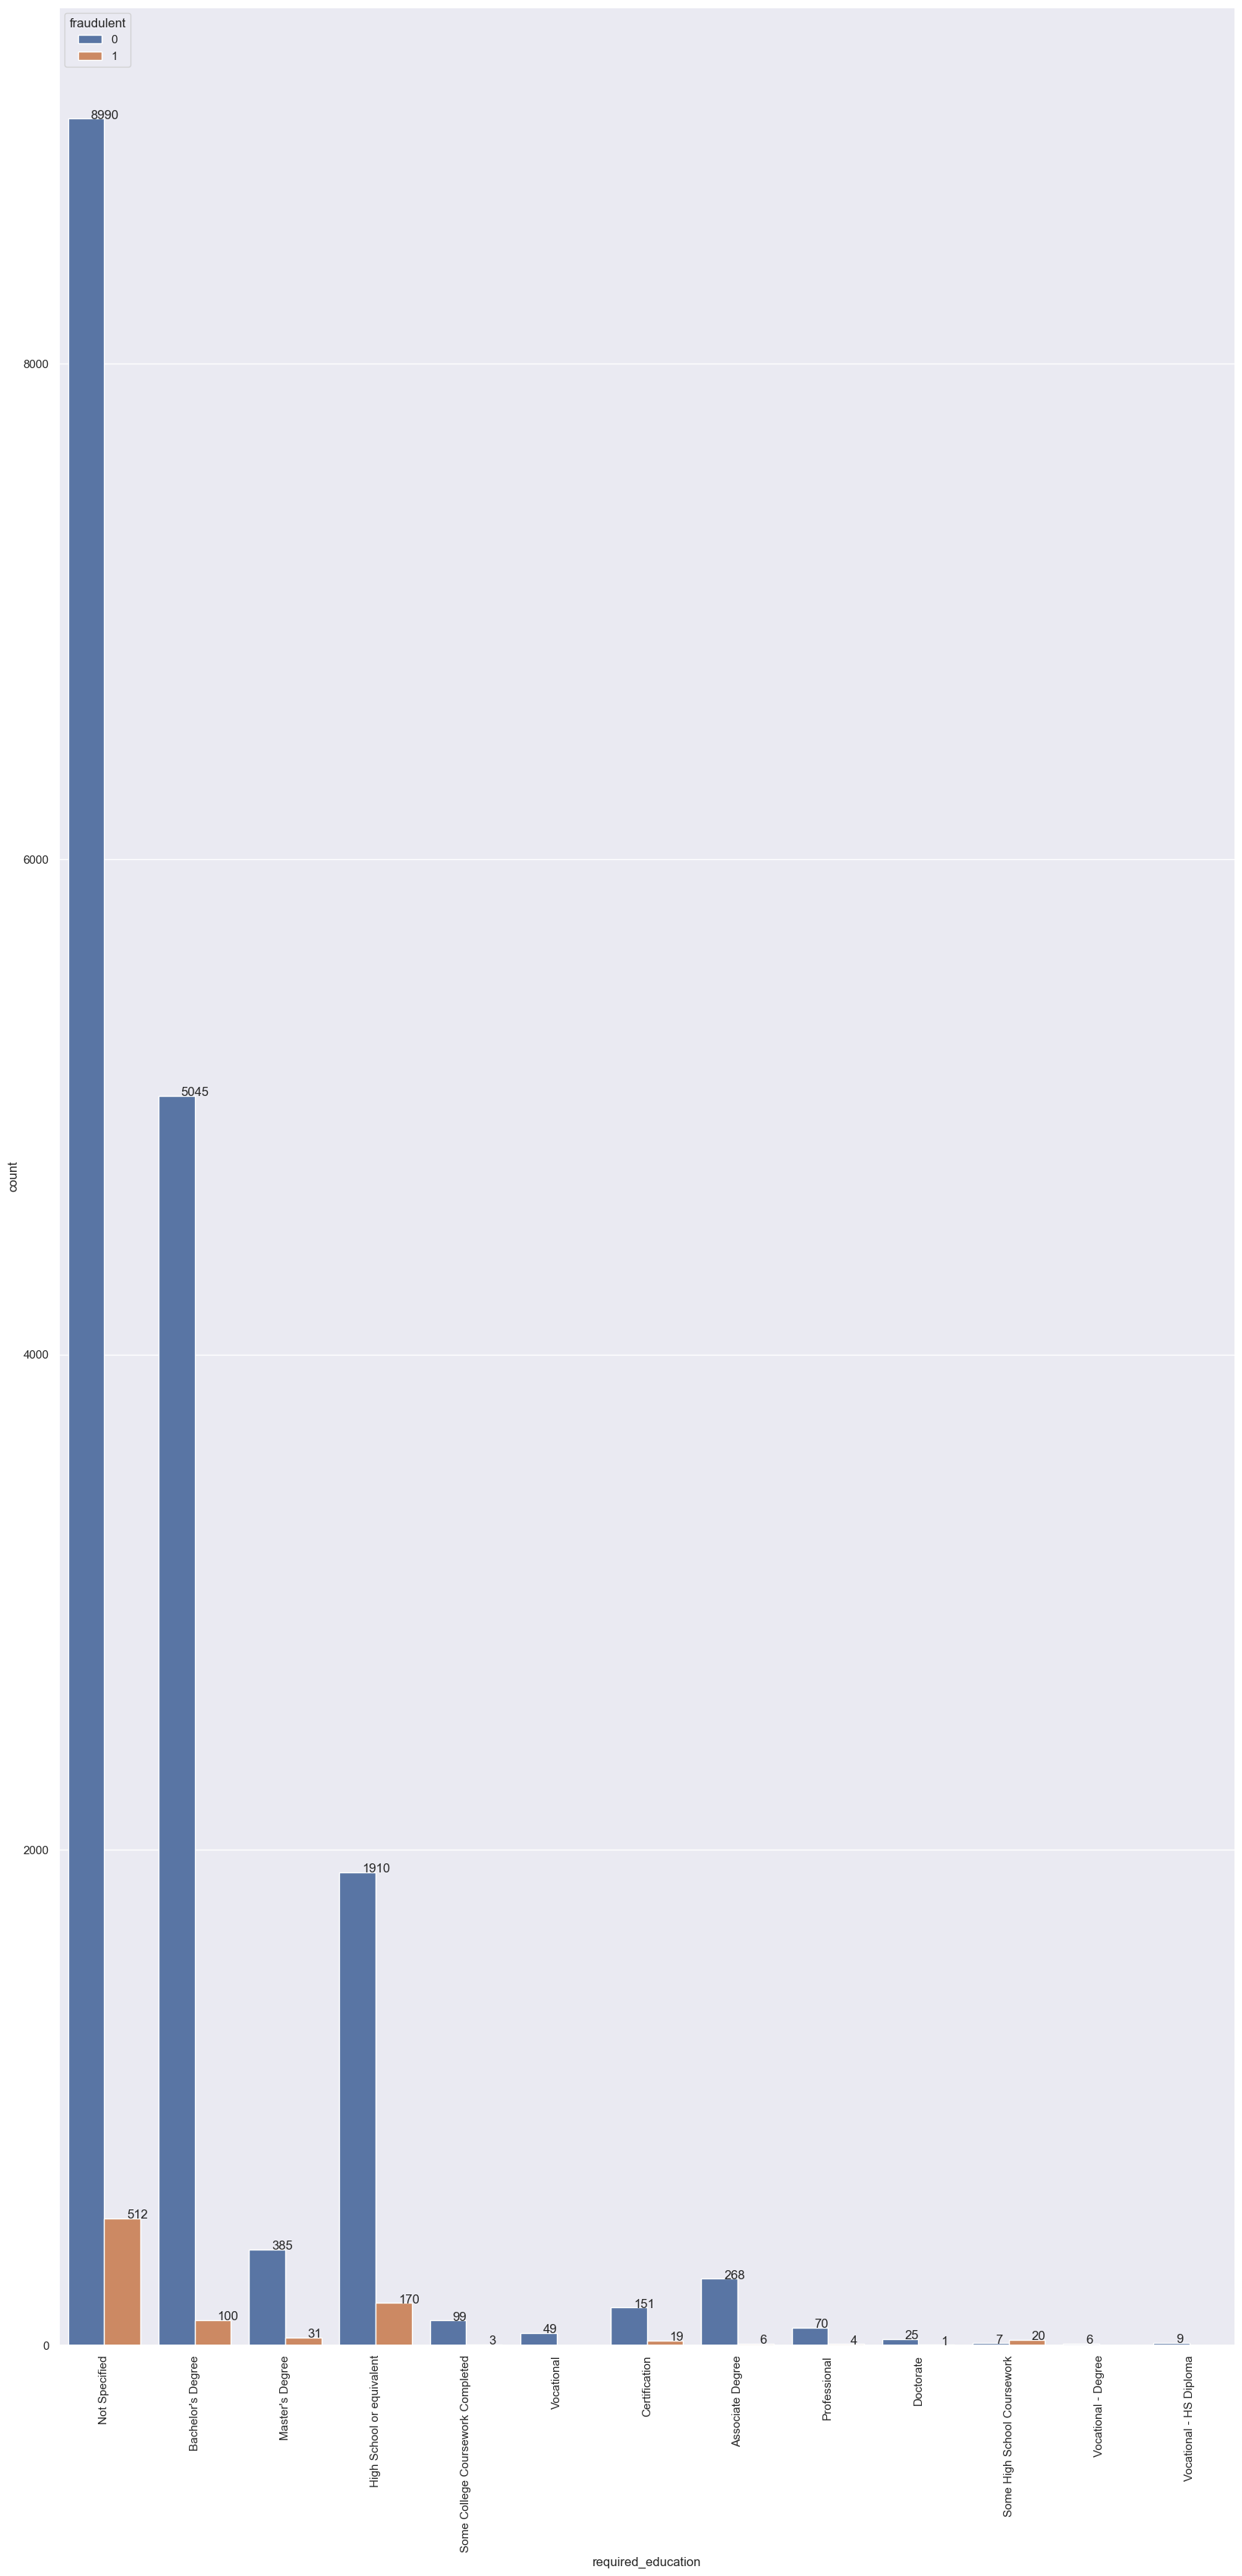

In [18]:
plots(label[5],'fraudulent')#required_education

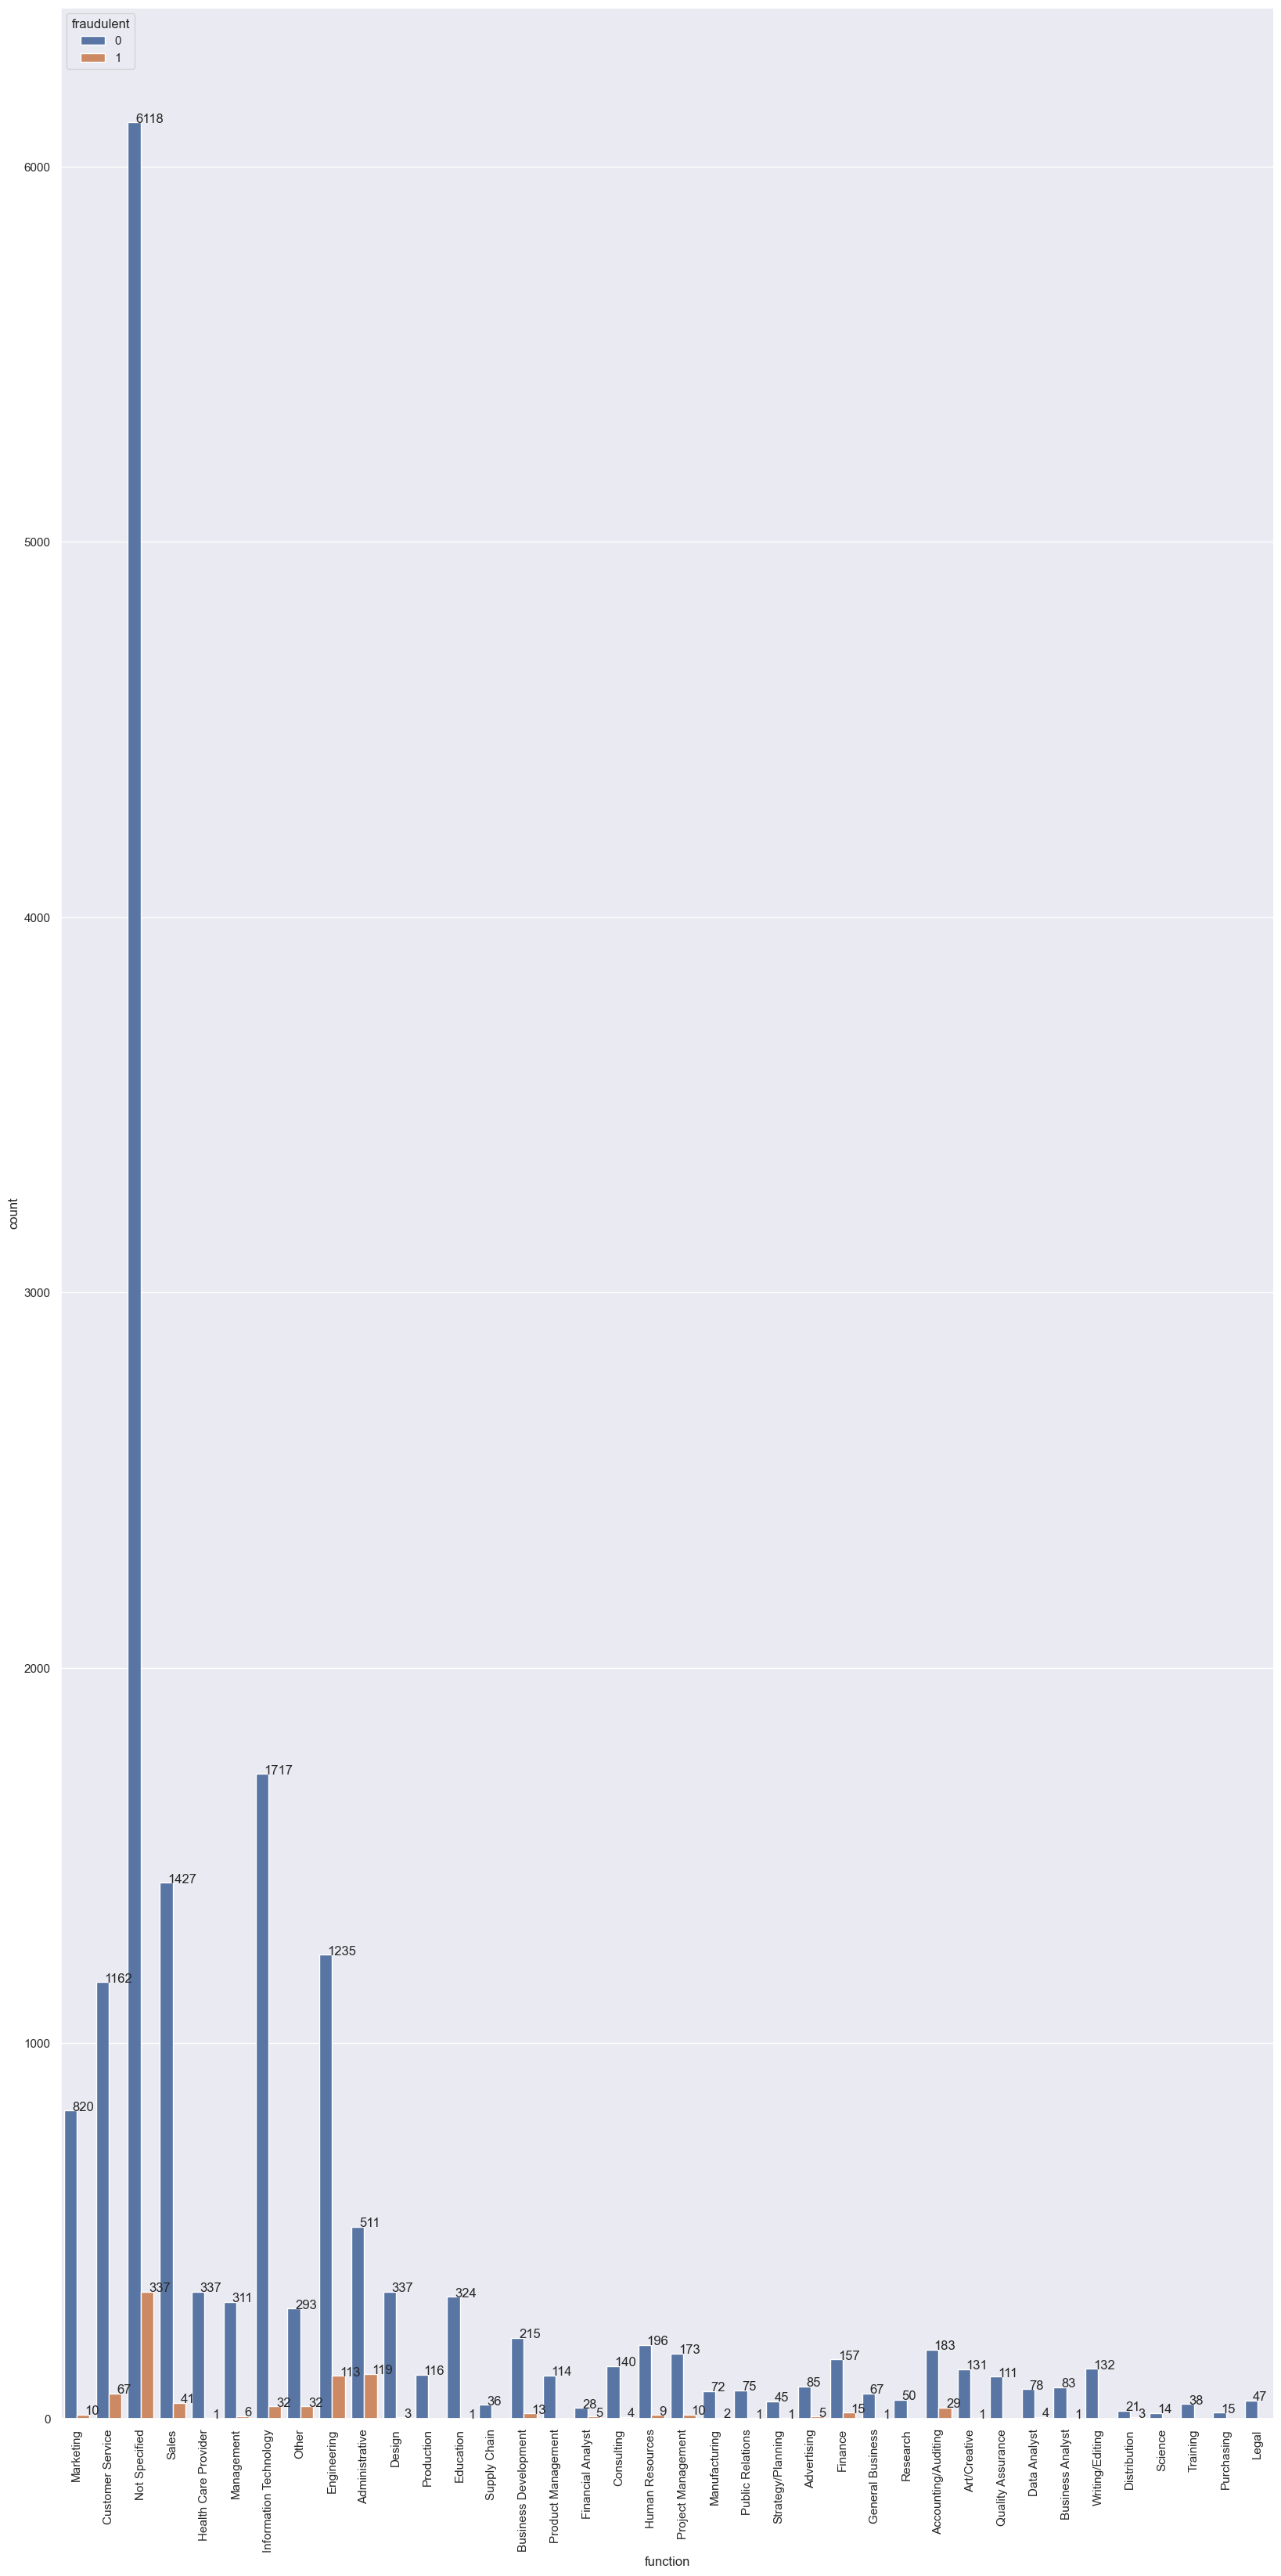

In [19]:
plots(label[6],'fraudulent')#function

# INFERENCE

From the above graphs, we can say that the number of real applicants is more than that of fake applicants given any label from the attributes plotted apart from 'Some High School Coursework' label in 'required_education' attribute. We can also find the labels which have a larger probability of being a real or fake application from the plots.

Telecommuting - A real job offer has more chances of providing telecommuting compared to that of a fake job.

Company Logo - A fake job offer has more chances of having a company logo compared to that of a real job.

Questions - A real job offer has more chances of providing questions compared to that of a fake job.

Employement - Even though Full-Time jobs have the most number of real job offers, a job that provides Temporary employement has the highest probability of providing real jobs compared to the rest and Part-Time employement has the least probability.

Experience - Even though jobs that did not specify experience level have the most number of real job offers, a job that requires Associate level experience has the highest probability of providing real jobs compared to the rest and Part-Time employement has the least proobability.

Education - Even though jobs that did not specify any required education has the most number of real job offers, A job that requires a Bachelor's degree has the highest probability of providing real jobs compared to the rest while job that requires some high school coursework has the least chances of offering a real job. Vocational Degree and Vocational Diploma don't have any fake job offers.

Functions - 'Production','Supply Chain','Product Management','Research','Quality Assurance','Writing/Editing','Science','Training','Purchasing','Legal' functions dont have any fake job offers. While 'Engineering' and 'Administrative' have more than 100 fake job offers and jobs that didn't provide any functions have the most number of fake job offers (300). Other functions have too little to no fake job offers.

## TEXT CLEANING

In [20]:
#REMOVING STOPWORDS AND SYMBOLS FROM ATTRIBUTES WITH LENGTHY TEXTS (['company_profile','description','requirements','benefits'])
nltk.download('stopwords')
stop = stopwords.words()
sym = "!@#$%^&*+-={}[]|\"':;<>,.?/`~()_" #SYMBOLS TO BE REMOVED
listsym = ([*sym])
listsym.append("'")
listsym.append('"')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
string_labels = ['company_profile','description','requirements','benefits']
for label in string_labels:
    df1[label] =  df1[label].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    for j in range(df1.shape[0]):
        for i in listsym:
            df1.at[j,label] = df1.at[j,label].replace(i,"")

### DATA ANALYSIS - NOT SPECIFIED

In [22]:
realcount = (df1['fraudulent']==0).sum() #Number of real applications
fakecount = (df1['fraudulent']==1).sum() #Number of fake applications


# FUNCTION TO CALCULATE THE NUMBER OF NOT SPECIFIED ENTRIES IN VARIOUS ATTRIBUTES ALONG WITH THE RATIO 
# OF NOT SPECIFIED TO REAL AND FAKE APPLICATIONS

def not_specified(labelname,name):   
    df_real = pd.DataFrame(df1[labelname].loc[df1['fraudulent']==0])
    notspecreal = (df_real[labelname]=='Not Specified').sum()
    print(name +'\n-----------------\n\nREAL\n-----------\nNumber of Real applications that have not specified ' + name + ' = {:.0f}'.format(notspecreal))
    print('Number of Real applications = {:.0f}'.format(realcount))
    print('Ratio (Not Specified Real applications / Real applications) = {:.6f}'.format(notspecreal/realcount))
    df_fake = pd.DataFrame(df1[labelname].loc[df1['fraudulent']==1])
    notspecfake = (df_fake[labelname]=='Not Specified').sum()
    print('\n\nFAKE\n-----------\nNumber of Fake applications that have not specified ' + name + ' = {:.0f}'.format(notspecfake))
    print('Number of Fake applications = {:.0f}'.format(fakecount))
    print('Ratio (Not Specified Fake applications / Fake applications) = {:.6f}'.format(notspecfake/fakecount))

for i in df1.columns:
    not_specified(i,i.upper())
    print('\n')

TITLE
-----------------

REAL
-----------
Number of Real applications that have not specified TITLE = 0
Number of Real applications = 17014
Ratio (Not Specified Real applications / Real applications) = 0.000000


FAKE
-----------
Number of Fake applications that have not specified TITLE = 0
Number of Fake applications = 866
Ratio (Not Specified Fake applications / Fake applications) = 0.000000


LOCATION
-----------------

REAL
-----------
Number of Real applications that have not specified LOCATION = 327
Number of Real applications = 17014
Ratio (Not Specified Real applications / Real applications) = 0.019219


FAKE
-----------
Number of Fake applications that have not specified LOCATION = 19
Number of Fake applications = 866
Ratio (Not Specified Fake applications / Fake applications) = 0.021940


DEPARTMENT
-----------------

REAL
-----------
Number of Real applications that have not specified DEPARTMENT = 11016
Number of Real applications = 17014
Ratio (Not Specified Real applicatio

### DATA ANALYSIS - WORD FREQUENCY

In [23]:
#FUNCTION TO RETURN THE 20 MOST FREQUENTLY OCCURING WORDS IN REAL/FAKE APPLCATIONS GIVEN THE ATTRIBUTE

#GIVEN WHETHER AN APPLICATION IS REAL OR FAKE, THE PROBABILITY OF THE WORD APPEARING IN THAT CATEGORY IS DIPLAYED

def frequent(lab,key):
    
    list_of_words = []
    if key == "real":
        f=0
        count = realcount
    else:
        f=1
        count = fakecount
    
    for i in (df1[lab].loc[df1['fraudulent']==f]):
        list_of_words.append((' '.join(dict.fromkeys(i.split()))))

    rand = ' '.join(list_of_words)
    listx = list(rand.split(" "))
    ratiolist = list(pd.Series(listx).value_counts()/count)
    _count = pd.DataFrame(pd.Series(listx).value_counts())
    _count. rename(columns = {_count.columns[0]:'Count'}, inplace = True)
    _count['Probability'] = ratiolist
    print("Frequently appearing words in " + lab + " of " + key + " applications")
    print(_count.head(20))
    list_of_words.clear()

In [24]:
frequent('location','real')
frequent('location','fake')

Frequently appearing words in location of real applications
           Count  Probability
US,         9868     0.579993
GB,         2353     0.138298
CA,         2351     0.138180
,           2085     0.122546
NY,         1191     0.070001
London      1105     0.064947
LND,         986     0.057952
GR,          937     0.055072
San          829     0.048725
TX,          823     0.048372
New          807     0.047432
York         766     0.045022
I,           688     0.040437
Athens       568     0.033384
Francisco    498     0.029270
IL,          477     0.028036
DE,          398     0.023393
FL,          385     0.022628
IN,          380     0.022335
OH,          354     0.020806
Frequently appearing words in location of fake applications
             Count  Probability
US,            725     0.837182
CA,            155     0.178984
TX,            152     0.175520
Houston         92     0.106236
NY,             68     0.078522
,               57     0.065820
San             57     0.0

In [25]:
frequent('department','real')
frequent('department','fake')

Frequently appearing words in department of real applications
             Count  Probability
Not          11016     0.647467
Specified    11016     0.647467
Sales          627     0.036852
Marketing      507     0.029799
Engineering    481     0.028271
Operations     328     0.019278
Development    298     0.017515
IT             263     0.015458
Product        220     0.012931
Services       182     0.010697
Technology     170     0.009992
Customer       126     0.007406
&              121     0.007112
Design         101     0.005936
Management      97     0.005701
Service         93     0.005466
and             92     0.005407
Finance         87     0.005113
Information     86     0.005055
Business        83     0.004878
Frequently appearing words in department of fake applications
                    Count  Probability
Not                   531     0.613164
Specified             531     0.613164
Engineering            56     0.064665
&                      31     0.035797
Energy   

In [26]:
frequent('salary_range','real')
frequent('salary_range','fake')

Frequently appearing words in salary_range of real applications
              Count  Probability
Not           14369     0.844540
Specified     14369     0.844540
0-0             138     0.008111
40000-50000      65     0.003820
30000-40000      51     0.002998
45000-67000      37     0.002175
25000-30000      32     0.001881
70000-90000      30     0.001763
80000-100000     30     0.001763
50000-80000      29     0.001704
55000-75000      28     0.001646
50000-70000      28     0.001646
35000-45000      27     0.001587
60000-80000      27     0.001587
40000-60000      26     0.001528
40000-45000      25     0.001469
25000-35000      24     0.001411
30000-50000      24     0.001411
30000-35000      24     0.001411
50000-60000      23     0.001352
Frequently appearing words in salary_range of fake applications
               Count  Probability
Specified        643     0.742494
Not              643     0.742494
7200-1380000      10     0.011547
30000-50000        8     0.009238
250000-50

In [27]:
frequent('company_profile','real')
frequent('company_profile','fake')

Frequently appearing words in company_profile of real applications
            Count  Probability
We           7580     0.445515
team         4493     0.264077
work         4463     0.262313
Our          4289     0.252087
company      4202     0.246973
companies    3374     0.198307
business     2986     0.175503
services     2983     0.175326
The          2854     0.167744
Not          2774     0.163042
Specified    2721     0.159927
solutions    2645     0.155460
technology   2622     0.154108
clients      2574     0.151287
amp          2520     0.148113
world        2398     0.140943
time         2330     0.136946
experience   2182     0.128247
working      2095     0.123134
great        2039     0.119842
Frequently appearing words in company_profile of fake applications
            Count  Probability
Specified     587     0.677829
Not           587     0.677829
Our           142     0.163972
Solutions      92     0.106236
technology     92     0.106236
We             89     0.10277

In [28]:
frequent('description','real')
frequent('description','fake')

Frequently appearing words in description of real applications
             Count  Probability
team          8470     0.497825
work          7257     0.426531
We            6458     0.379570
The           5503     0.323440
experience    5083     0.298754
company       4723     0.277595
business      4670     0.274480
development   4027     0.236687
customer      3947     0.231985
working       3745     0.220113
management    3450     0.202774
support       3388     0.199130
This          3322     0.195251
amp           3309     0.194487
including     3305     0.194252
role          3257     0.191431
position      3254     0.191254
product       3143     0.184730
skills        3088     0.181498
based         3045     0.178970
Frequently appearing words in description of fake applications
             Count  Probability
work           467     0.539261
We             357     0.412240
team           254     0.293303
experience     252     0.290993
company        248     0.286374
skills    

In [29]:
frequent('requirements','real')
frequent('requirements','fake')

Frequently appearing words in requirements of real applications
               Count  Probability
experience      9434     0.554485
work            5722     0.336311
skills          5617     0.330140
years           5478     0.321970
communication   4635     0.272423
knowledge       3448     0.202657
ability         3424     0.201246
degree          3368     0.197955
team            3230     0.189844
working         3217     0.189080
written         3204     0.188316
required        2939     0.172740
Not             2596     0.152580
management      2589     0.152169
Specified       2550     0.149877
related         2290     0.134595
development     2236     0.131421
understanding   2211     0.129952
customer        2207     0.129717
verbal          2174     0.127777
Frequently appearing words in requirements of fake applications
               Count  Probability
experience       366     0.422633
work             267     0.308314
skills           266     0.307159
years            214  

In [30]:
frequent('requirements','real')
frequent('requirements','fake')

Frequently appearing words in requirements of real applications
               Count  Probability
experience      9434     0.554485
work            5722     0.336311
skills          5617     0.330140
years           5478     0.321970
communication   4635     0.272423
knowledge       3448     0.202657
ability         3424     0.201246
degree          3368     0.197955
team            3230     0.189844
working         3217     0.189080
written         3204     0.188316
required        2939     0.172740
Not             2596     0.152580
management      2589     0.152169
Specified       2550     0.149877
related         2290     0.134595
development     2236     0.131421
understanding   2211     0.129952
customer        2207     0.129717
verbal          2174     0.127777
Frequently appearing words in requirements of fake applications
               Count  Probability
experience       366     0.422633
work             267     0.308314
skills           266     0.307159
years            214  

In [31]:
frequent('industry','real')
frequent('industry','fake')

Frequently appearing words in industry of real applications
                    Count  Probability
Not                  4628     0.272011
Specified            4628     0.272011
Services             3100     0.182203
and                  2983     0.175326
Information          1728     0.101563
Technology           1702     0.100035
Computer             1565     0.091983
Software             1371     0.080581
&                    1095     0.064359
Internet             1062     0.062419
Management           1027     0.060362
Education             839     0.049312
Marketing             783     0.046021
Advertising           783     0.046021
Financial             744     0.043729
Care                  469     0.027566
Health                469     0.027566
Consumer              458     0.026919
Hospital              446     0.026214
Telecommunications    316     0.018573
Frequently appearing words in industry of fake applications
                    Count  Probability
Not                   

## PREPROCESSING

In [32]:
le = preprocessing.LabelEncoder()
#ASSIGNS NUMBER TO EVERY LABEL
for i in df1.columns:
    le.fit(df1[i])
    df1[i]=le.transform(df1[i])

In [33]:
df1.head(5)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,6043,2536,758,872,1548,4038,3684,3038,0,1,0,3,4,6,88,22,0
1,2183,1073,1162,872,15,6855,10491,5350,0,1,0,1,6,6,75,7,0
2,1763,1868,831,872,1393,7017,4514,3038,0,1,0,2,6,6,88,23,0
3,299,1704,1055,872,946,9211,3077,3174,0,1,0,1,5,1,22,32,0
4,975,1742,831,872,1182,5258,6540,2114,0,1,1,1,5,1,51,16,0


## MODEL

In [34]:
X=df1.drop(['fraudulent'],axis=1)
Y=df1["fraudulent"]
X_train,X_test,Y_train,Y_test = (train_test_split(X, Y, test_size=0.25, shuffle=True))

In [35]:
#FUNCTION TO TRAIN THE MODEL, PREDICT THE LABELS FOR TEST SAMPLES AND CALCULATE THE ACCURACY AND PRECISION

def traintest(model,modelname):
    
    start = time.time()
    print("\n------------------\nMODEL - "+ modelname + "\n-----------------\n")

    #Training the model
    model.fit(X_train, Y_train) 

    #Predicting 
    Y_pred = model.predict(X_test)

    #Calculating the accuracy
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    print("Accuracy = " + '{:.2f}%'.format(accuracy*100))

    #Calculating the precision
    precision = metrics.precision_score(Y_test, Y_pred)
    print("Precision = " + '{:.2f}%'.format(precision*100))

    #Total Time
    end = time.time() - start
    print("Time = " + '{:.2f}s'.format(end))

In [36]:
#ACCURACY ALONG WITH THE TIME IS NOTED FOR THIS PURPOSE

import warnings
warnings.filterwarnings('ignore')  

traintest(GaussianNB(),"NAIVE BAYES")
traintest(DecisionTreeClassifier(),"DECISION TREE")
traintest(RandomForestClassifier(),"RANDOM FOREST")
traintest(KNeighborsClassifier(),"KNN")
traintest(SVC(),"SVM")
traintest(LogisticRegression(solver='liblinear'),"LOGISITC REGRESSION")


------------------
MODEL - NAIVE BAYES
-----------------

Accuracy = 93.53%
Precision = 30.69%
Time = 0.04s

------------------
MODEL - DECISION TREE
-----------------

Accuracy = 96.64%
Precision = 64.60%
Time = 0.31s

------------------
MODEL - RANDOM FOREST
-----------------

Accuracy = 98.12%
Precision = 95.21%
Time = 4.60s

------------------
MODEL - KNN
-----------------

Accuracy = 95.59%
Precision = 58.72%
Time = 2.70s

------------------
MODEL - SVM
-----------------

Accuracy = 95.17%
Precision = 0.00%
Time = 8.44s

------------------
MODEL - LOGISITC REGRESSION
-----------------

Accuracy = 95.35%
Precision = 70.00%
Time = 0.74s
